<a href="https://colab.research.google.com/github/chicocasanova/mvp_sprint_1/blob/main/Entrega_MVP_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Machine Learning
O dataset que estou utilizando é relativo à estadia de clientes em um hotel e tem várias informações interessantes sobre eles e sobre suas expectativas quanto a hospedagem.
###Objetivo
Esse é um problema de classificação e minha meta neste projeto é treinar um modelo que predite se um novo hóspede irá cancelar ou não sua reserva. Essa é uma informação muito relevante para o negócio porque assim poderá prever e mitigar o prejuízo causado pelos cancelamentos.

###Dicionário dos atributos do dataset

* Booking_ID: identificador individual de cada reserva.
* no_of_adults: número de adultos.
* no_of_children: número de crianças.
* no_of_weekend_nights: números de noites (sábados ou domingos) em que o hóspede ficou no hotel.
* no_of_week_nights: números de noites (segunda à sexta) em que o hóspede ficou no hotel.
* type_of_meal_plan: tipo de comida que ele agendou:
required_car_parking_space: o hóspede pediu para usar o estacionamento? (0 - não, 1- sim).
* room_type_reserved: Tipo de quarto escolhido. os valores são cifrados segundo a rede INN Hotels.
* lead_time: número de dias entre o dia em que foi feita a reserva e o dia da chegada.
* arrival_year: ano da data de chegada.
* arrival_month: mês da data de chegada.
* arrival_date: dia do mês da chegada.
* market_segment_type: o cliente veio de qual segmento de marketing.
* repeated_guest: o hóspede já veio outra vez? (0 - não, 1- sim)
* no_of_previous_cancellations: número de cancelamentos de reservas anteriores a reserva atual.
* no_of_previous_bookings_not_canceled: número de não cancelamentos de reservas anteriores a reserva atual.
* avg_price_per_room: preço médio por dia da reserva; o preço dos quartos é dinâmico (em euro).
* no_of_special_requests: número total de pedidos especiais feitos pelo hóspede (ex.: andar alto, vista do quarto, etc)
* booking_status: Flag dizendo se a reserva foi ou não cancelada.



##1. Fazendo os imports

In [49]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd                                     # Biblioteca pandas
import numpy as np                                      # Biblioteca numpy
import matplotlib.pyplot as plt                         # Biblioteca matplotlib
import seaborn as sns                                   # Visualização gráfica de dados
from sklearn.preprocessing import RobustScaler          # Para fazer a padronização
from imblearn.over_sampling import SMOTE                # Para fazer o oversampling
from sklearn.model_selection import train_test_split    # Para fazer o split de treino e teste
from sklearn.model_selection import KFold               # Para fazer validação cruzada
from sklearn.model_selection import StratifiedKFold     # validação cruzada com estratificação
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV        # Para fazer o tuning dos hiperparâmetros
from sklearn.metrics import classification_report       # Report das classificações
from sklearn.metrics import precision_recall_curve      # Curva de precisão e recall
from sklearn.metrics import confusion_matrix            # Matriz de confusão
from sklearn.metrics import f1_score                    # F1 score
from sklearn.metrics import accuracy_score              # Acurácia
from sklearn.metrics import precision_score             # Precisão
from sklearn.metrics import recall_score                # Recall
#from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression     # Modelo de regressão logística
from sklearn.tree import DecisionTreeClassifier         # Modelo de árvores de decisão
from sklearn.neighbors import KNeighborsClassifier      # Modelo de KNN
from sklearn.ensemble import RandomForestClassifier     # Modelo de random forest

##2. Carregando e visualizando o dataset
###Constatações iniciais
* Algumas colunas tem valores categóricos nominais e uma ordinal, que posteriormente serão convertidos.
* O dataset tem 36.275 linhas e 19 colunas mas logo no início retirei a booking_id, que se refere ao identificador de cada reserva e não terá uso para o treinamento do modelo.
* Não há nenhum missing value e nem nada duplicado.

In [50]:
# Carregando e testando o dataset
df = pd.read_csv('https://raw.githubusercontent.com/chicocasanova/mvp_sprint_1/main/Hotel%20Reservations.csv') # importando o dataset
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [51]:
# Visualização do shape dos dados
print('\nData Shape')
print('='*50)
print("Número de colunas: ", df.shape[1])
print("Número de linhas: ", df.shape[0])



Data Shape
Número de colunas:  19
Número de linhas:  36275


In [52]:
def categorical_data(data):
    # Identificando as colunas que contém valores categóricos
    cat_columns = data.select_dtypes(['object']).columns

    for col in cat_columns:
        # Removendo espaços em branco e transformando todos os caracteres em minúsculas
        data[col] = data[col].str.strip()
        data[col] = data[col].str.lower()

        # OQ FAZER COM ISSO Substituindo todos os caracteres especiais exceto os alphanuméricos, espaços e travessões por ' '
        data[col] = data[col].str.replace('[^a-zA-Z0-9\s-]', '', regex=True)

    return data

# Checando se há linhas duplicadas
def check_duplicates(df):
    duplicate_rows = df[df.duplicated()]

    if not duplicate_rows.empty:
        print("Total de linhas duplicadas:", len(duplicate_rows))
        for column in df.columns:
            print(f"Número de linhas duplicadas em {column}: {df[column].duplicated().sum()}")
    else:
        print("Não foram encontradas colunas duplicadas!")

def time_line_analysis(df, column_name):
    # Contando as ocorrências de cada valor único nas colunas
    data_counts = df[column_name].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    plt.plot(data_counts.index, data_counts.values, marker='o', linestyle='-')

    plt.title(f"Line Chart for {column_name}")
    plt.ylabel("Frequency")
    plt.xlabel(column_name)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [53]:
# Checando se há linhas duplicadas
def check_duplicates(df):
    duplicate_rows = df[df.duplicated()]

    if not duplicate_rows.empty:
        print("Total de linhas duplicadas:", len(duplicate_rows))
        for column in df.columns:
            print(f"Número de linhas duplicadas em {column}: {df[column].duplicated().sum()}")
    else:
        print("Não foram encontradas colunas duplicadas!")

In [54]:
#CONFERIR ESSE CÓDIGO

def time_line_analysis(df, column_name):
    # Contando as ocorrências de cada valor único nas colunas
    data_counts = df[column_name].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    plt.plot(data_counts.index, data_counts.values, marker='o', linestyle='-')

    plt.title(f"Line Chart for {column_name}")
    plt.ylabel("Frequency")
    plt.xlabel(column_name)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [55]:
df.drop('Booking_ID', axis = 1, inplace = True) # Retirando a coluna ID

df = categorical_data(df)
df.info() # Print com informações sobre a forma do dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          36275 non-null  int64  
 1   no_of_children                        36275 non-null  int64  
 2   no_of_weekend_nights                  36275 non-null  int64  
 3   no_of_week_nights                     36275 non-null  int64  
 4   type_of_meal_plan                     36275 non-null  object 
 5   required_car_parking_space            36275 non-null  int64  
 6   room_type_reserved                    36275 non-null  object 
 7   lead_time                             36275 non-null  int64  
 8   arrival_year                          36275 non-null  int64  
 9   arrival_month                         36275 non-null  int64  
 10  arrival_date                          36275 non-null  int64  
 11  market_segment_

In [56]:
check_duplicates(df) # Checando se há linhas duplicados

Total de linhas duplicadas: 10275
Número de linhas duplicadas em no_of_adults: 36270
Número de linhas duplicadas em no_of_children: 36269
Número de linhas duplicadas em no_of_weekend_nights: 36267
Número de linhas duplicadas em no_of_week_nights: 36257
Número de linhas duplicadas em type_of_meal_plan: 36271
Número de linhas duplicadas em required_car_parking_space: 36273
Número de linhas duplicadas em room_type_reserved: 36268
Número de linhas duplicadas em lead_time: 35923
Número de linhas duplicadas em arrival_year: 36273
Número de linhas duplicadas em arrival_month: 36263
Número de linhas duplicadas em arrival_date: 36244
Número de linhas duplicadas em market_segment_type: 36270
Número de linhas duplicadas em repeated_guest: 36273
Número de linhas duplicadas em no_of_previous_cancellations: 36266
Número de linhas duplicadas em no_of_previous_bookings_not_canceled: 36216
Número de linhas duplicadas em avg_price_per_room: 32345
Número de linhas duplicadas em no_of_special_requests: 36

In [57]:
print("Quantidade de features únicas")
print("=" * 50)
df.nunique()

Quantidade de features únicas


no_of_adults                               5
no_of_children                             6
no_of_weekend_nights                       8
no_of_week_nights                         18
type_of_meal_plan                          4
required_car_parking_space                 2
room_type_reserved                         7
lead_time                                352
arrival_year                               2
arrival_month                             12
arrival_date                              31
market_segment_type                        5
repeated_guest                             2
no_of_previous_cancellations               9
no_of_previous_bookings_not_canceled      59
avg_price_per_room                      3930
no_of_special_requests                     6
booking_status                             2
dtype: int64

In [58]:
# Calculando o número de missing values pra cada feature
missing_values = df.isnull().sum()

# Filtrando as features que não tem missing values
missing_values = missing_values[missing_values > 0]

# Exibindo missing values
if not missing_values.empty:
    print("Número de missing values para cada feature:")
    print(missing_values)
else:
    print("Não foi encontrado nenhum missing value no dataset!")


Não foi encontrado nenhum missing value no dataset!


##3. Análise exploratória
*Como não fiz a sprint anterior (essa é minha primeira) não aprofundarei muito a etapa de análise exploratória porque não sei fazê-la (mas tentarei esboçar algo).*
<br><br>
Comecei convertendo para int, através de mapping, os valores das colunas categóricas ordinais, e por one-hot encoding, o da classe a ser predita.
###Constatações
* A maior parte das reservas é para 2 adultos, conforme os dados do Q3 (terceiro quartil).
* O mês de maior procura é Julho, o que faz todo o sentido porque acredito que esse hotel seja europeu já que os valores dos quartos estão em euro e esse é um dos meses de mais alta temporada para fazer turismo por lá.
* Não há muitos hóspedes crianças. 75% das reservas não tem.
* 75% das pessoas se hospedam sábado e domingo. Em geral elas ficam mais dias durante a semana do que nos fins de semana.
* Poucos hóspedes pedem para usar o estacionamento.
* O tempo de antecedência no qual as reservas tem um altíssimo desvio padrão mas a média é de mais ou menos 3 meses.
* Esses dados são referentes a hóspedes que estiveram no hotel entre os anos de 2017 e 2018.
* Parece que não há muitos hóspedes que voltam a se hospedar no hotel.
* Pelo motivo acima, não há muitos dados de clientes que, ao voltar, cancelaram ou não sua reserva.
* O preço médio por quarto varia bastante, afinal eles utilizam valores flutuantes.
* Para minha surpresa, pedidos especiais são incomuns mas não raros.
* 33% das pessoas cancelam suas reservas, um número bem alto. Isso indica também que esta classe está muito desbalanceada. Mais a frente, realizarei um oversample com SMOTE para lidar com isso.

Como alguns atributos aparentemente importantes tem altíssimo desvio padrão e valores mínimos e máximos muito discrepantes (ex.: lead_time e avg_price_per_room), tudo indica que teremos muitos outliers e isso pode impactar o treinamento do modelo. Mitigarei isso utilizando o Robust scaling, assim os dados serão dimensionados no intervalo interquartil (IQR).

Os atributos com maior impacto sobre a classe target são o lead_time arrival_year avg_price_per_room e no_of_special_requests. O arrival_year não tem relevância porque todos os hóspedes são de 2017 e 2018, por isso mais a frente farei o drop desta coluna.

In [59]:
# Fazendo um mapping dos valores categóricos ordinais para numéricos
market_segment_type = {
    'offline': 0,
    'online': 1,
    'corporate': 2,
    'complementary': 3,
    'aviation': 4
}

# Transpondo esses valores para a coluna referente
df['market_segment_type'] = df['market_segment_type'].map(market_segment_type)

# Fazendo um mapping dos valores categóricos ordinais para numéricos
meal_plan_mapping = {
    'not selected': 0,
    'meal plan 1': 1,
    'meal plan 2': 2,
    'meal plan 3': 3
}

# Transpondo esses valores para a coluna referente
df['type_of_meal_plan'] = df['type_of_meal_plan'].map(meal_plan_mapping)

# Fazendo um mapping dos valores categóricos ordinais para numéricos
room_type_mapping = {
    "roomtype 1" : 0,
    "roomtype 2" : 1,
    "roomtype 3" : 2,
    "roomtype 4" : 3,
    "roomtype 5" : 4,
    "roomtype 6" : 5,
    "roomtype 7" : 6}

# Transpondo esses valores para a coluna referente
df['room_type_reserved'] = df['room_type_reserved'].map(room_type_mapping)

# Fazendo one-hot encoding da classe target
hotStatus = pd.get_dummies(df['booking_status'], prefix='booking_status')

# Concatenando os atributos gerados ao DataFrame
df = pd.concat([df, hotStatus], axis=1)

# Dropping as colunas de booking status e de uma das geradas pelo one-hot encoding
df.drop(['booking_status', 'booking_status_notcanceled'], axis=1, inplace=True)

# Renomeando a coluna target para 'canceled'
df.rename(columns={'booking_status_canceled': 'canceled'}, inplace=True)

# Convertendo o data type dela para integers
df["canceled"] = df["canceled"].astype(int)
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,canceled
0,2,0,1,2,1,0,0,224,2017,10,2,0,0,0,0,65.00,0,0
1,2,0,2,3,0,0,0,5,2018,11,6,1,0,0,0,106.68,1,0
2,1,0,2,1,1,0,0,1,2018,2,28,1,0,0,0,60.00,0,1
3,2,0,0,2,1,0,0,211,2018,5,20,1,0,0,0,100.00,0,1
4,2,0,1,1,0,0,0,48,2018,4,11,1,0,0,0,94.50,0,1


In [60]:
# Criando uma função para estilizar o texto
def style_description(s):
    return f'font-weight: normal;'

print('Descrição das variáveis:')
numeric_data = df.describe(include=['int64', 'float64']).T

print("=" * 50)
# Apply the styling to the DataFrame
styled_description = numeric_data.style.applymap(style_description)
styled_description

Descrição das variáveis:


,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.000000,1.844962,0.518715,0.000000,2.000000,2.000000,2.000000,4.000000
no_of_children,36275.000000,0.105279,0.402648,0.000000,0.000000,0.000000,0.000000,10.000000
no_of_weekend_nights,36275.000000,0.810724,0.870644,0.000000,0.000000,1.000000,2.000000,7.000000
no_of_week_nights,36275.000000,2.204300,1.410905,0.000000,1.000000,2.000000,3.000000,17.000000
type_of_meal_plan,36275.000000,0.949966,0.480191,0.000000,1.000000,1.000000,1.000000,3.000000
required_car_parking_space,36275.000000,0.030986,0.173281,0.000000,0.000000,0.000000,0.000000,1.000000
room_type_reserved,36275.000000,0.708890,1.399851,0.000000,0.000000,0.000000,0.000000,6.000000
lead_time,36275.000000,85.232557,85.930817,0.000000,17.000000,57.000000,126.000000,443.000000
arrival_year,36275.000000,2017.820427,0.383836,2017.000000,2018.000000,2018.000000,2018.000000,2018.000000
arrival_month,36275.000000,7.423653,3.069894,1.000000,5.000000,8.000000,10.000000,12.000000


In [61]:
# Matriz de correlação das features com a classe target
print("### correlation matrix #######")
correlationMatrix = df.corr()
print(correlationMatrix["canceled"])

### correlation matrix #######
no_of_adults                            0.086920
no_of_children                          0.033078
no_of_weekend_nights                    0.061563
no_of_week_nights                       0.092996
type_of_meal_plan                       0.049374
required_car_parking_space             -0.086185
room_type_reserved                      0.022986
lead_time                               0.438538
arrival_year                            0.179529
arrival_month                          -0.011233
arrival_date                            0.010629
market_segment_type                    -0.039368
repeated_guest                         -0.107287
no_of_previous_cancellations           -0.033728
no_of_previous_bookings_not_canceled   -0.060179
avg_price_per_room                      0.142569
no_of_special_requests                 -0.253070
canceled                                1.000000
Name: canceled, dtype: float64


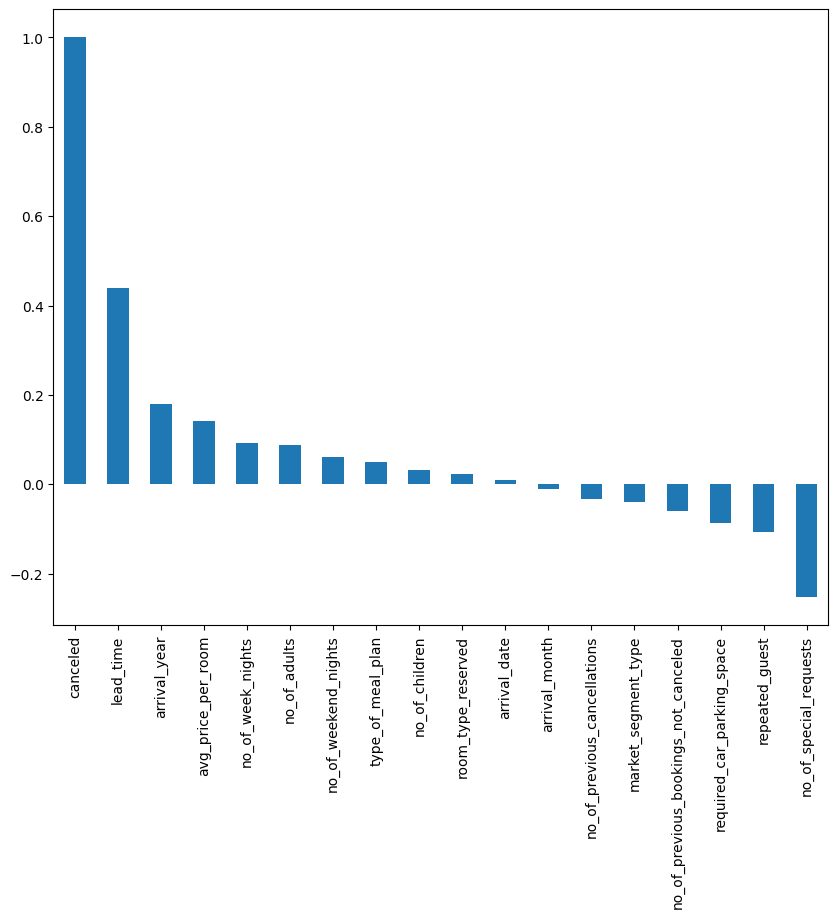

In [62]:
# Incluíndo a classe 'canceled' como target na correlação
target_corr = df.corr()['canceled'].sort_values(ascending=False)

# Plotando a correlação
plt.figure(figsize=(10, 8))
target_corr.plot(kind='bar')
plt.show()

In [63]:
# Calculando a porcentagem de cancelamentos e não cancelamentos (0 = não cancelado / 1 = cancelado)
print('Porcentagem de não cancelamentos (0) e  cancelamentos (1)')
print("=" * 50)
porcentagem_cancelamentos = df['canceled'].value_counts(normalize=True) * 100  # Multiplicando por 100 para obter a porcentagem
print(porcentagem_cancelamentos)

Porcentagem de não cancelamentos (0) e  cancelamentos (1)
canceled
0    67.236389
1    32.763611
Name: proportion, dtype: float64


##4. Feature engineering

Farei o drop de alguns atributos que não interessam por que parecem não ter uma razoável relação de causalidade com a classe a ser predita e também porque traríam muitos outliers à toa, gerando ruídos para a construção do modelo. São os dados relativos ao ano, mês e dia da estadia, e ao número de dias de hospedagem nos fins de semana e dias de semana.

In [64]:
df = df.drop(['arrival_year', 'arrival_month', 'arrival_date', "no_of_week_nights", "no_of_weekend_nights"], axis=1)
df.head()

,no_of_adults,no_of_children,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,canceled
0,2,0,1,0,0,224,0,0,0,0,65.00,0,0
1,2,0,0,0,0,5,1,0,0,0,106.68,1,0
2,1,0,1,0,0,1,1,0,0,0,60.00,0,1
3,2,0,1,0,0,211,1,0,0,0,100.00,0,1
4,2,0,0,0,0,48,1,0,0,0,94.50,0,1


##5. Pré-processamento de dados
Dividi meu dataset em treino e teste utilizando 20% para teste e 80% para treino. Utilizei estratificação porque o custo computacional não é um problema nesse caso, e porque quero que os modelos tenham uma performance mais confiável e estável em virtude da diminuição da variância proporcionada.<br><br>

Conforme explicado na etapa de análise exploratória, alguns atributos importantes geraram muitos outliers e isso pode impactar no treinamento do modelo. Mitiguei isso utilizando o Robust scaling, redimensionando os dados no intervalo interquartil.<br><br>

Além disso, a classe target relativa ao cancelamento ou não da reserva estava muito desbalanceada, com apenas 33% de cancelamentos, o que poderia criar um modelo com forte viés para classificações de não cancelamento. Para resolver esse desbalanceamento, fiz um oversampling utilizando SMOTE (apenas nos grupos de treinamento, para não haver data leakage e manter a integridade do teste, que deve ser feita com dados do "mundo real"), que irá igualar as 2 classes a partir da criação de dados sintéticos.<br><br>

É importante citar que coloquei o SMOTE após o RobustScaler porque  ele cria dados baseados na distância entre as amostras, se eu colocasse ele antes, poderia gerar dados sintéticos "piores", sob forte influência dos outliers.<br><br>




In [65]:
X = df.drop('canceled', axis=1)   # Features
y = df['canceled']                # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 42, stratify=y) # usando estratificação

In [66]:
scaler = RobustScaler() # fazendo padronização dos dados

X_train_scaled = scaler.fit_transform(X_train) # criando 2 variáveis para armazenar os dados padronizados
X_test_scaled = scaler.transform(X_test)

In [67]:
sm = SMOTE(random_state=42) # fazendo o oversampling
X_resampled, y_resampled = sm.fit_resample(X_train_scaled, y_train) # criando 2 variáveis para armazenar os dados balanceados

##6. Criando e testando os modelos
Utilizei os algoritmos RandomForestClassifier, DecisionTreeClassifier LogisticRegression e KNeighborsClassifier para criar hipóteses para esse problema de classificação.<br><br>
Treinei os modelos com os datasets padronizados e balanceados.

In [68]:
# Definindo modelos
rf_model = RandomForestClassifier()
dt_model = DecisionTreeClassifier()
logistic_model = LogisticRegression()
knn_model = KNeighborsClassifier()

# Treinando modelos
rf_model.fit(X_resampled, y_resampled)
dt_model.fit(X_resampled, y_resampled)
logistic_model.fit(X_resampled, y_resampled)
knn_model.fit(X_resampled, y_resampled)

# Avaliando os modelos no grupo de teste
rf_predictions = rf_model.predict(X_test_scaled)
dt_predictions = dt_model.predict(X_test_scaled)
logistic_predictions = logistic_model.predict(X_test_scaled)
knn_predictions = knn_model.predict(X_test_scaled)

# Criando os reports de classificação
rf_report = classification_report(y_test, rf_predictions, output_dict=True)
dt_report = classification_report(y_test, dt_predictions, output_dict=True)
logistic_report = classification_report(y_test, logistic_predictions, output_dict=True)
knn_report = classification_report(y_test, knn_predictions, output_dict=True)

##7. Análise das performances
Antes de analisar as performances tenho que falar das métricas.<br><br>

Para esse problema, julgo que a acurácia seja muito importante porque, para um hotel, a previsão do cancelamento ou não da reserva de um cliente pode ajudar a criar medidas que diminuam o prejuízo causado pelo cancelamento. Entretanto, os dados são muito desbalanceados, pouca gente cancela de fato, então julgo que o f1 score seja mais adequado, assim teria um modelo com boa generalização. Afinal, a precisão e o recall parecem importantes, porque se um cliente o qual a reserva foi prevista como confirmada, vier a cancelar, o hotel é pego de surpresa e não pode tomar as medidas para mitigar o cancelamento. Da mesma maneira, se eles tomarem certas medidas pensando no cancelamento e o cliente vier, isso também pode trazer um problema.<br><br>

Analisando as métricas dos resultados, o algoritmo que se saiu melhor em todas foi o RandomForestClassifier. Tracei uma curva de precisão e recall para visualizar os dados e fica evidente que o mérito do RF.<br><br>

A partir daí, realizei com ajuda do gridsearchCSV o tuning de seus hiperparâmetros (ele demorou pouco menos de 2h, cuidado ao dar play no código).<br><br>



In [69]:
# Métricas dos reports de classificação
rf_metrics = [rf_report['weighted avg']['f1-score'], rf_report['weighted avg']['recall'], rf_report['accuracy'], rf_report['weighted avg']['precision']]
dt_metrics = [dt_report['weighted avg']['f1-score'], dt_report['weighted avg']['recall'], dt_report['accuracy'], dt_report['weighted avg']['precision']]
logistic_metrics = [logistic_report['weighted avg']['f1-score'], logistic_report['weighted avg']['recall'], logistic_report['accuracy'], logistic_report['weighted avg']['precision']]
knn_metrics = [knn_report['weighted avg']['f1-score'], knn_report['weighted avg']['recall'], knn_report['accuracy'], knn_report['weighted avg']['precision']]

# Colocando as métricas em uma tabela para visualização
evaluation_df = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'Logistic Regression', 'KNN'],
    'F1 Score': [rf_metrics[0], dt_metrics[0], logistic_metrics[0], knn_metrics[0]],
    'Recall': [rf_metrics[1], dt_metrics[1], logistic_metrics[1], knn_metrics[1]],
    'Accuracy': [rf_metrics[2], dt_metrics[2], logistic_metrics[2], knn_metrics[2]],
    'Precision': [rf_metrics[3], dt_metrics[3], logistic_metrics[3], knn_metrics[3]]
})

evaluation_df

,Model,F1 Score,Recall,Accuracy,Precision
0,Random Forest,0.871076,0.870710,0.870710,0.871547
1,Decision Tree,0.852833,0.851826,0.851826,0.854464
2,Logistic Regression,0.776677,0.772295,0.772295,0.787179
3,KNN,0.850984,0.848932,0.848932,0.855931


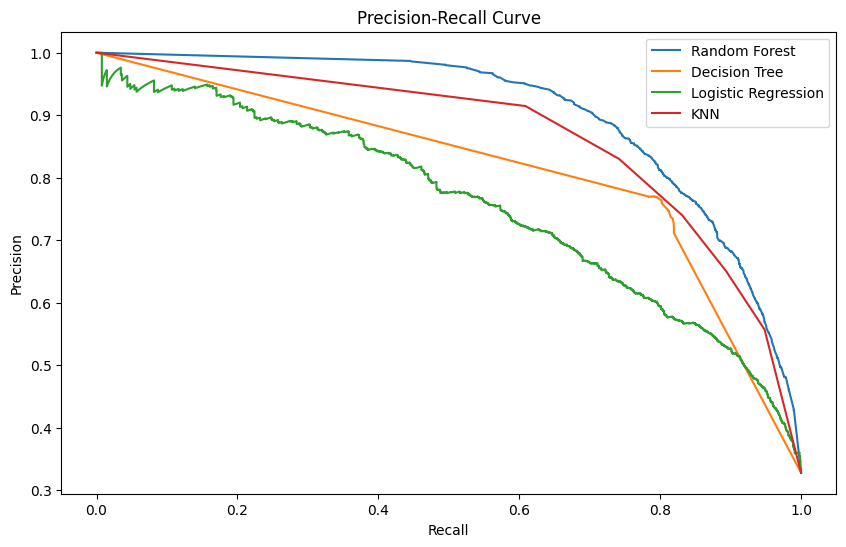

In [70]:
# Plotando as curvas de Precision-Recall
plt.figure(figsize=(10, 6))

# Plot Precision-Recall Curve for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(recall_rf, precision_rf, label='Random Forest')

# Plot Precision-Recall Curve for Decision Tree
precision_dt, recall_dt, _ = precision_recall_curve(y_test, dt_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(recall_dt, precision_dt, label='Decision Tree')

# Plot Precision-Recall Curve for Logistic Regression
precision_logistic, recall_logistic, _ = precision_recall_curve(y_test, logistic_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(recall_logistic, precision_logistic, label='Logistic Regression')

# Plot Precision-Recall Curve for KNN
precision_knn, recall_knn, _ = precision_recall_curve(y_test, knn_model.predict_proba(X_test_scaled)[:, 1])
plt.plot(recall_knn, precision_knn, label='KNN')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

##8. Conclusão
O modelo final foi exposto à validação cruzada com estratificação, visando lidar com o desbalanceamento das classes target, aumentando a estabilidade e a generalização, obtendo um ótimo f1 score, mostrando que ele tem uma ótima relação precisão x recall e a acurácia também foi alta. Confesso que achei os resultados estranhamente otimistas, como próximos passos, investigaria se está ocorrendo algum vazamento de dados ou alguma outra anomalia importante.<br><br>
Fiquei com curiosidade de fazer uma etapa melhor de análise exploratória para entender melhor a relação entre as features. Gostaria também de conversar com alguém que entenda do ramo de hotelaria para entender melhor a relação de causalidade dessas features.

In [ ]:
### CUIDADO, DEMORA 2 HORAS PARA RODAR ###

# usando gridsearch para encontrar melhores parâmetros para o RF
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10, 15, 20],
    'n_estimators': [100, 150, 200]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_resampled, y_resampled)

best_rf = grid_search.best_estimator_
rf_predictions = best_rf.predict(X_test_scaled)
rf_report = classification_report(y_test, rf_predictions)
print("Best Random Forest parameters:", grid_search.best_params_)
print("Classification Report:\n", rf_report)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


In [47]:
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

for train_index, test_index in stratified_kfold.split(X_resampled, y_resampled):
    # Split the data into training and test sets for this fold
    X_train_fold, X_test_fold = X_resampled[train_index], X_resampled[test_index]
    y_train_fold, y_test_fold = y_resampled[train_index], y_resampled[test_index]

    # Train the RandomForestClassifier on the training data for this fold
    rf_model.fit(X_train_fold, y_train_fold)

    # Get the predicted labels for the test set
    y_pred_fold = rf_model.predict(X_test_fold)

    # Calculate metrics for this fold
    acc_fold = accuracy_score(y_test_fold, y_pred_fold)
    prec_fold = precision_score(y_test_fold, y_pred_fold, zero_division=0)
    rec_fold = recall_score(y_test_fold, y_pred_fold, zero_division=0)
    f1_fold = f1_score(y_test_fold, y_pred_fold)

    # Append each score to the respective list
    accuracy_list.append(acc_fold)
    precision_list.append(prec_fold)
    recall_list.append(rec_fold)
    f1_score_list.append(f1_fold)

average_accuracy = sum(accuracy_list) / n_splits
average_precision = sum(precision_list) / n_splits
average_recall = sum(recall_list) / n_splits
average_f1_score = sum(f1_score_list) / n_splits

# Print the average of each metric
print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1_score)


Average Accuracy: 0.885429519052796
Average Precision: 0.8880780519598769
Average Recall: 0.8820212421860564
Average F1 Score: 0.8850360273891725


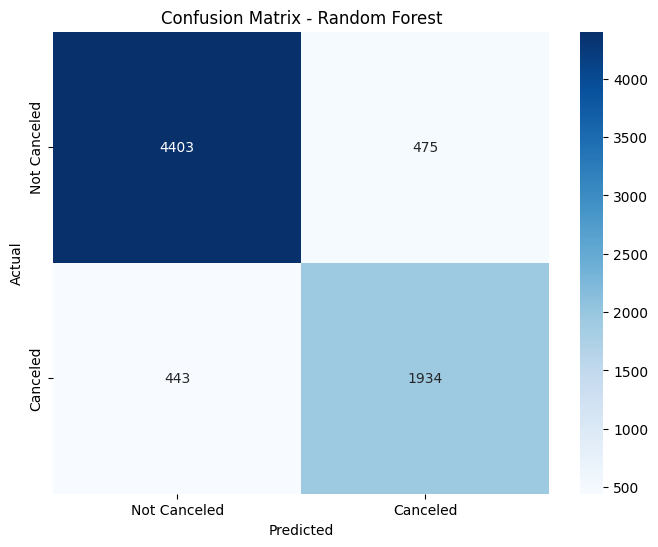

In [162]:
# Criando uma matriz de confusão
conf_matrix_rf = confusion_matrix(y_test, rf_predictions)

# Plotando the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Canceled', 'Canceled'], yticklabels=['Not Canceled', 'Canceled'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()